### **STANDFORD DOG DATASETS**

## **Introduction**
Dataset has 20,580 dogs images in 120 categories

In this project, i will use AlexNet for multiclass image classification.

Object is picking different categories of dog images for CNN model. After training, we will check the accuracy of the CNN model to predict the dog's categories. 





# **0. Setup in Google Colab**
By using Google Colab, i can access the library and package quickly and google colab calculate very fast.
I load the datasets from Kaggle and use the pipeline to load to Google Colab

In [0]:
 ! pip install -q kaggle

In [0]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"giangbinh","key":"74974761777fc38733a28d815d81563a"}'}

In [0]:
 from google.colab import files

files.upload()

Saving model_evaluation_utils.py to model_evaluation_utils.py


{'model_evaluation_utils.py': b'# -*- coding: utf-8 -*-\n"""\nCreated on Mon Jul 31 20:05:23 2017\n\n@author: DIP\n"""\n\nfrom sklearn import metrics\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.base import clone\nfrom sklearn.preprocessing import label_binarize\nfrom scipy import interp\nfrom sklearn.metrics import roc_curve, auc \n\n\ndef get_metrics(true_labels, predicted_labels):\n    \n    print(\'Accuracy:\', np.round(\n                        metrics.accuracy_score(true_labels, \n                                               predicted_labels),\n                        4))\n    print(\'Precision:\', np.round(\n                        metrics.precision_score(true_labels, \n                                               predicted_labels,\n                                               average=\'weighted\'),\n                        4))\n    print(\'Recall:\', np.round(\n                     

In [0]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

stanford-dogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
! unzip stanford-dogs-dataset.zip -d stanford-dogs-dataset

In [0]:
!ls

'kaggle (1).json'   model_evaluation_utils.py   stanford-dogs-dataset
 kaggle.json	    sample_data		        stanford-dogs-dataset.zip


In [0]:
%matplotlib inline

# **1. Load all the libraries**
Exploring the dataset to look at the classes/breeds of the dogs to understand more about its structure

In [0]:
# Display the Folders/Classes

import numpy as np
import pandas as pd 
import os


print(os.listdir('stanford-dogs-dataset/images/Images/'))
dog_classes = os.listdir('stanford-dogs-dataset/images/Images/')

['n02107574-Greater_Swiss_Mountain_dog', 'n02096294-Australian_terrier', 'n02090379-redbone', 'n02088364-beagle', 'n02112350-keeshond', 'n02088466-bloodhound', 'n02105251-briard', 'n02090622-borzoi', 'n02085782-Japanese_spaniel', 'n02106382-Bouvier_des_Flandres', 'n02099267-flat-coated_retriever', 'n02108422-bull_mastiff', 'n02106166-Border_collie', 'n02111500-Great_Pyrenees', 'n02101388-Brittany_spaniel', 'n02087394-Rhodesian_ridgeback', 'n02094433-Yorkshire_terrier', 'n02091032-Italian_greyhound', 'n02108000-EntleBucher', 'n02096051-Airedale', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02105641-Old_English_sheepdog', 'n02085936-Maltese_dog', 'n02097298-Scotch_terrier', 'n02097209-standard_schnauzer', 'n02097130-giant_schnauzer', 'n02093647-Bedlington_terrier', 'n02097047-miniature_schnauzer', 'n02102177-Welsh_springer_spaniel', 'n02087046-toy_terrier', 'n02105162-malinois', 'n02101556-clumber', 'n02107683-Bernese_mountain_dog', 'n02088238-basset', 'n02093256-Staffordsh

There are 120 subfolders, each belonging to 1 of the 120 dog breeds. For example, images of the Chow breed are under the subfolder n02107574-Greater_Swiss_Mountain_dog. We then proceed to extract the name of the dog breeds by splitting the folder name.

In [0]:
# Get the dog labels

breeds = [breed.split('-',1)[1] for breed in dog_classes] # get labels by splitting the folder name at dash
breeds[:10] # view some of the labels

['Greater_Swiss_Mountain_dog',
 'Australian_terrier',
 'redbone',
 'beagle',
 'keeshond',
 'bloodhound',
 'briard',
 'borzoi',
 'Japanese_spaniel',
 'Bouvier_des_Flandres']

Then, for each of the images, we get the full path to the image (stored in X), as well as its associated label/class/breed (stored in y). This allows us to load the images easily.

In [0]:
# Get images full path and their labels

from itertools import chain

X = []
y = []

fullpaths = ['stanford-dogs-dataset/images/Images/{}'.format(dog_class) for dog_class in dog_classes]

for counter, fullpath in enumerate(fullpaths):
    for imgname in os.listdir(fullpath):
        X.append([fullpath + '/' + imgname])
        y.append(breeds[counter])

X = list(chain.from_iterable(X)) # unnest the lists and join together into one list

len(X) # number of pictures

20580

# **2. Suffle and Plot Images**
Shuffle the images and their labels together so that they are not grouped by their breeds.




In [0]:
# Random shuffle the images for learning

import random

# shuffle X and y
combined = list(zip(X, y))
random.shuffle(combined)

X[:], y[:] = zip(*combined)

And look at a sample batch of the dog images with their associated labels. Notice that the images have different dimensions, so we will have to resize them later before putting them into the model

In [0]:
# Display random dogs pictures 

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.image import imread

plt.figure(figsize=(30,40))
for counter, i in enumerate(random.sample(range(0, len(X)), 25)): # random 25 images
    plt.subplot(5, 5, counter+1)
    plt.subplots_adjust(hspace=0.1)
    filename = X[i]
    image = imread(filename)
    plt.imshow(image)
    plt.title(y[i], fontsize=20)

    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Choose a subset to test code

X = X[:4000]
y = y[:4000]

In [0]:
# Convert labels to one-hot encoded labels

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Label and one-hot encoding y labels
le = LabelEncoder()
le.fit(y)
y_ohe = to_categorical(le.transform(y), len(breeds))
y_ohe = np.array(y_ohe)

Using TensorFlow backend.


# **3. Prepare data for training the CNN model**

  - Now it's time to prepare our training, validation and testing dataset. We do this using the train_test_split function from the sklearn module. But before that, we load the images to the same dimensions and convert them into an image array, each containing the rgb values of every pixel.

In [0]:
# Prepare train, validation and test data
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img

img_data = np.array([img_to_array(load_img(img, target_size = (299,299)))
                     for img in X]) # load, resize images, and store as array

x_train, x_test, y_train, y_test = train_test_split(img_data, y_ohe,
                                                   test_size = 0.2,
                                                   stratify=np.array(y), # stratify makes sure that proportion of each class in the output is same as the input
                                                   random_state = 2) 

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                 test_size = 0.2,
                                                 stratify=np.array(y_train),
                                                 random_state = 2)

print('Training Dataset Size: ', x_train.shape)
print('Validation Dataset Size: ', x_val.shape)
print('Testing Dataset Size: ', x_test.shape)
print('Training Label Size: ', y_train.shape)
print('Validation Label Size: ', y_val.shape)
print('Testing Label Size: ', y_test.shape)

# clear some space from memory
import gc
del img_data
gc.collect()

Training Dataset Size:  (2560, 299, 299, 3)
Validation Dataset Size:  (640, 299, 299, 3)
Testing Dataset Size:  (800, 299, 299, 3)
Training Label Size:  (2560, 120)
Validation Label Size:  (640, 120)
Testing Label Size:  (800, 120)


22

We can see that we have 2560 training, 640 validation,and 800 testing images. Each image has a 299x299 dimension, with 3 channels, representing the RGB channels.

# **4.Data Augmentation**
We also perform data augmentation, especially if we have a small dataset, to give us significantly more diverse data without collecting them. This works by applying some transformation to our images (e.g., rotation, axis flipping) to produce 'new' versions of existing images, thus giving us more data to train with.

In [0]:
# Data Augmentation

from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# Create train generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, # only use rescale=1./255 if training from scratch
                                  rotation_range = 30,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  horizontal_flip = True) # CHECK

train_generator = train_datagen.flow(x_train, y_train,
                                     shuffle = False, batch_size = batch_size, seed = 1)

# Create validation generator
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # do not augment validation data

val_generator = val_datagen.flow(x_val, y_val,
                                shuffle = False, batch_size = batch_size, seed = 1)

- Below is an example of an image that was transformed into 'new' images. The model can then extract features from them and learn that these features are associated with this particular breed of dog.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


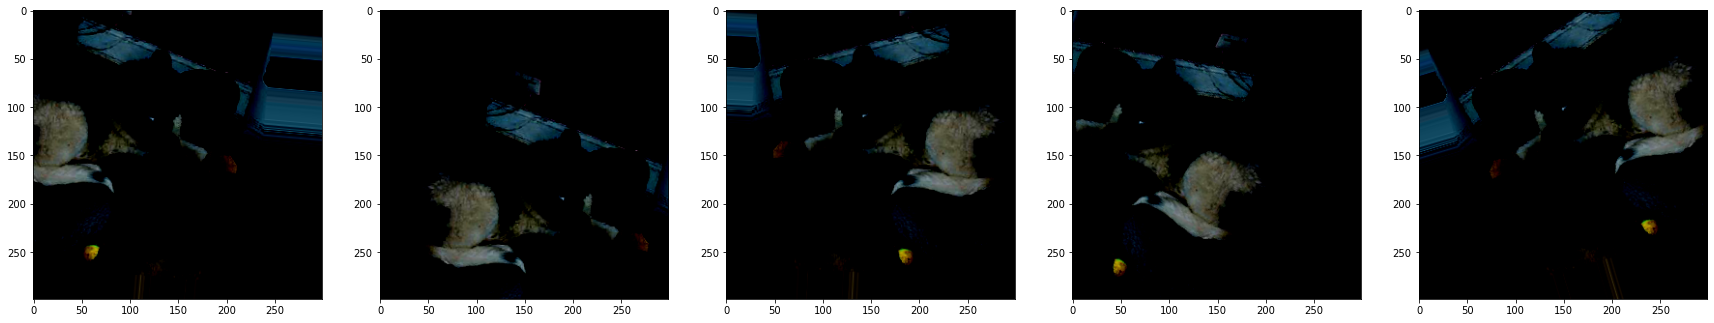

In [0]:
img_id = 16

dog_generator = train_datagen.flow(x_train[img_id:img_id+1], y_train[img_id:img_id+1],
                                     shuffle = False, batch_size = batch_size, seed = 1)

plt.figure(figsize=(30,20))
dogs = [next(dog_generator) for i in range(0,5)]
for counter, dog in enumerate(dogs): 
    plt.subplot(1, 5, counter+1)
    plt.imshow(dog[0][0])
    #plt.axis('off')
    
plt.show()

# **5. Model Building**
The next part is building the model. For this process, we are using Google's Inception V3 model. There are other models available to use in Keras as well. We remove the last layer of the Inception V3 model, and feed the output of it to our own set of layers, ending with a final Dense layer to classify or predict which of the 120 breeds the images belong to. We also freeze the initial Inception V3 model as it has already been trained before and compile the model.


In [0]:
# Build Model Using Pre-trained Model

from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# load InceptionV3 pre-trained model
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (299,299,3))

model = models.Sequential()
model.add(base_model) # add pre_trained layers
model.add(GlobalAveragePooling2D())
#model.add(Flatten()) # flatten to 1-D vector to prepare for fully connected layers
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(len(breeds), activation = 'softmax'))


# Freeze pre-trained layers
print('Number of trainable weights before freezing the base layer:', len(model.trainable_weights))
model.layers[0].trainable = False
print('Number of trainable weights after freezing the base layer:', len(model.trainable_weights))

87916544/87910968 [==============================] - 7s 0us/step
Number of trainable weights before freezing the base layer: 194
Number of trainable weights after freezing the base layer: 6


# **6. Model Training**
- It's finally time to train our model. The batch size is the number of images passed to the model for training during every iteration. Therefore, the number of iterations/steps is the number of images divided by the batch size, which constitues one epoch. After each iteration, weights of the nodes will be updated. An epoch ends when the entire dataset has been passed through. The more epoch we have, the more the model will train on the data.. 

In [0]:
# Compile the Model

model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 120)               61560     
Total params: 23,176,088
Trainable params: 1,373,304
Non-trainable params: 21,802,784
__________________________________

In [0]:

train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
epochs = 20

history = model.fit_generator(train_generator,
                             steps_per_epoch = train_steps_per_epoch,
                             validation_data = val_generator,
                             validation_steps = val_steps_per_epoch,
                             epochs = epochs, verbose = 1)

Epoch 1/20
80/80 [==============================] - 78s 970ms/step - loss: 4.7068 - accuracy: 0.0387 - val_loss: 4.3960 - val_accuracy: 0.2672
Epoch 2/20
80/80 [==============================] - 62s 777ms/step - loss: 4.2249 - accuracy: 0.2137 - val_loss: 3.5727 - val_accuracy: 0.5000
Epoch 3/20
80/80 [==============================] - 64s 798ms/step - loss: 3.3693 - accuracy: 0.3812 - val_loss: 2.4852 - val_accuracy: 0.6797
Epoch 4/20
80/80 [==============================] - 64s 797ms/step - loss: 2.4538 - accuracy: 0.5305 - val_loss: 1.7091 - val_accuracy: 0.7406
Epoch 5/20
80/80 [==============================] - 64s 799ms/step - loss: 1.8729 - accuracy: 0.5992 - val_loss: 1.3570 - val_accuracy: 0.7750
Epoch 6/20
80/80 [==============================] - 64s 801ms/step - loss: 1.5465 - accuracy: 0.6469 - val_loss: 1.1019 - val_accuracy: 0.8047
Epoch 7/20
80/80 [==============================] - 64s 802ms/step - loss: 1.3076 - accuracy: 0.6770 - val_loss: 1.0512 - val_accuracy: 0.8281

# **7. Accuracy and Loss Plots**


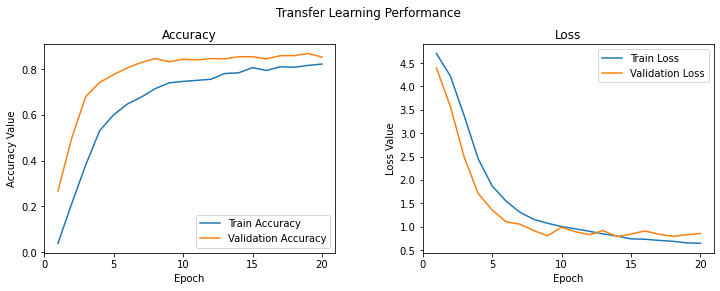

In [0]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Transfer Learning Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# **8. Prediction of Test Set**

In [0]:
# Evaluate Model on Test Data

x_test1 = x_test / 255. # rescale to 0-1. Divide by 255 as its the max RGB value
test_predictions = model.predict(x_test1)

# get model predictions
predictions = le.classes_[np.argmax(test_predictions,axis=1)] # get labels and reverse back to get the text labels
# get target labels
target_labels = le.classes_[np.argmax(y_test,axis=1)]

# Store in dataframe
predict_df = pd.DataFrame({'Target_Labels': target_labels, 'Predictions': predictions})
predict_df.head(20)

,Target_Labels,Predictions
0,pug,pug
1,Scottish_deerhound,Scottish_deerhound
2,papillon,papillon
3,dingo,dingo
4,kelpie,kelpie
5,Leonberg,Leonberg
6,Shetland_sheepdog,Shetland_sheepdog
7,Old_English_sheepdog,Old_English_sheepdog
8,Old_English_sheepdog,Old_English_sheepdog
9,Doberman,Doberman


In [0]:
# Get accuracy of measure

correct = (target_labels == predictions)
accuracy = correct.sum() / correct.size
print(accuracy)

0.84625


In [0]:
# Evaluate Model Performance

from model_evaluation_utils import get_metrics

get_metrics(true_labels=target_labels,
            predicted_labels=predictions)

Accuracy: 0.8462
Precision: 0.8584
Recall: 0.8462
F1 Score: 0.8395


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# Plot Actual vs Predicted Images with Confidence Levels
    
plt.figure(figsize=(30,40))
for counter, i in enumerate(random.sample(range(0, len(y_test)), 30)): # random 30 images
    plt.subplot(6, 5, counter+1)
    plt.subplots_adjust(hspace=0.6)
    actual = str(target_labels[i])
    predicted = str(predictions[i])
    conf = str(max(test_predictions[i]))
    plt.imshow(x_test[i]/255.0)
    plt.axis('off')
    plt.title('Actual: ' + actual + '\nPredict: ' + predicted + '\nConf: ' + conf, fontsize=18)
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.